,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,1,0,1,1,1.146148362,0,0.734203,36,0.08333333,0,0,1
2,1,1,1,1,0.002200337,0,0.734203,37,0.16666667,0,0,0
3,1,2,1,0,-0.481762418,0,0.734203,38,0.25000000,0,0,0
4,1,3,1,0,0.007872396,0,0.734203,39,0.33333333,0,0,0
5,1,4,1,1,0.216053715,0,0.734203,40,0.41666667,0,0,0
6,1,5,1,0,-0.057481504,0,0.734203,41,0.50000000,0,1,0


Trial Sequence Object 
Estimand: Intention-to-treat 
 
Data: 
 - N: 725 observations from 89 patients 
        id period treatment    x1           x2    x3        x4   age      age_s
     <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>
  1:     1      0         1     1  1.146148362     0 0.7342030    36 0.08333333
  2:     1      1         1     1  0.002200337     0 0.7342030    37 0.16666667
 ---                                                                           
724:    99      6         1     1 -0.033762356     1 0.5752681    71 3.00000000
725:    99      7         0     0 -1.340496520     1 0.5752681    72 3.08333333
     outcome censored eligible time_on_regime
       <num>    <int>    <num>          <num>
  1:       0        0        1              0
  2:       0        0        0              1
 ---                                         
724:       0        0        0              1
725:       1        0        0              2
 
IPW for infor

Weight Models for Informative Censoring
---------------------------------------

[[n]]
Model: P(censor_event = 0 | X) for numerator 
 
 term        estimate   std.error statistic p.value     
 (Intercept)  2.4480907 0.1405726 17.415128 6.334656e-68
 x2          -0.4486482 0.1368765 -3.277759 1.046346e-03
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 404.2156      724     -196.7002 397.4004 406.5727 393.4004 723         725 
 
 path                                                                                                       
 /var/folders/0s/y3hcxq2x71j_djfnfp03zn140000gn/T//Rtmpd8fts2/trial_itt/switch_models/model_7ee52ccb69ad.rds
 
[[d0]]
Model: P(censor_event = 0 | X, previous treatment = 0) for denominator 
 
 term        estimate   std.error statistic p.value     
 (Intercept)  1.8941961 0.2071122  9.145746 5.921948e-20
 x2          -0.5898292 0.1693402 -3.483101 4.956409e-04
 x1           0.8552603 0.3452930  2.476912 1.325247e-02
 
 null

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


- Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2) 
- Treatment variable: assigned_treatment 
- Adjustment variables: x2 
- Model fitter type: te_stats_glm_logit 
 
Model Summary: 
 
 term               estimate std.error statistic p.value conf.low conf.high
 (Intercept)        -6.02    0.780      -7.72    1.2e-14 -7.550   -4.4916  
 assigned_treatment  1.63    0.496       3.28    1.0e-03  0.654    2.5977  
 x2                  0.31    0.418       0.74    4.6e-01 -0.511    1.1282  
 followup_time       0.34    0.244       1.38    1.7e-01 -0.141    0.8148  
 I(followup_time^2) -0.02    0.014      -1.42    1.5e-01 -0.049    0.0077  
 trial_period        7.29    0.978       7.45    9.2e-14  5.371    9.2044  
 I(trial_period^2)  -7.68    0.537     -14.30    2.1e-46 -8.738   -6.6316  
 
 null.deviance df.null logLik AIC BIC deviance df.residual nobs
 158           800     -69.1  152 185 135      794         801 

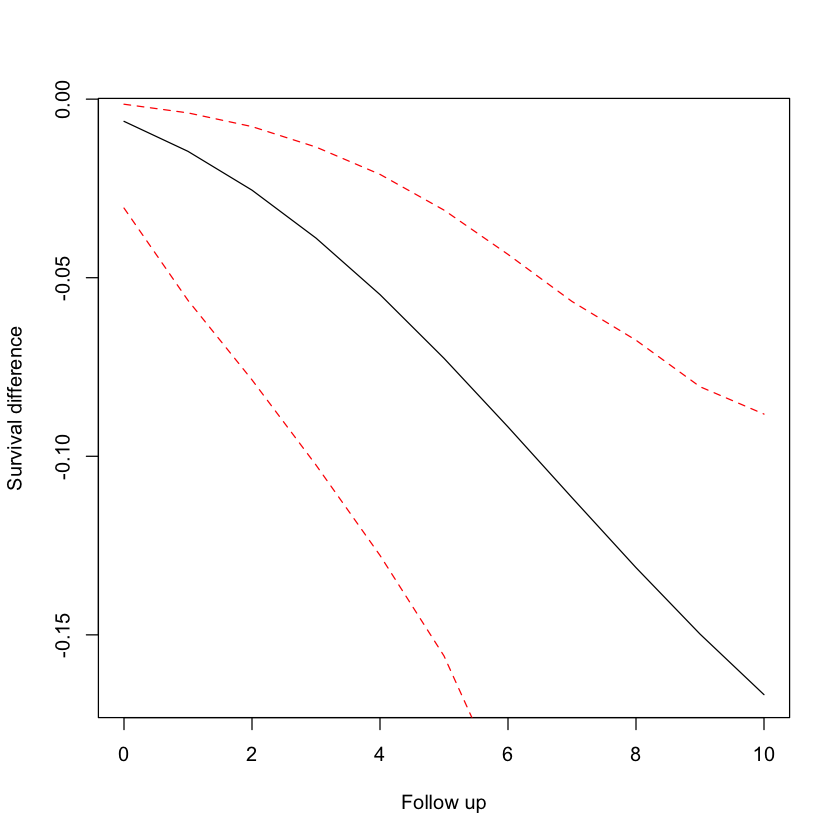

In [3]:
library(TrialEmulation)

# 1. Setup
trial_itt <- trial_sequence(estimand = "ITT")

# Create a directory to save files for later inspection
trial_itt_dir <- file.path(tempdir(), "trial_itt")
trial_itt_dir <- file.path(tempdir(), "trial_itt")
if (!dir.exists(trial_itt_dir)) {
  dir.create(trial_itt_dir)
}

# 2. Data preparation
# Load dummy dataset
data("data_censored") 

# Display first few rows
head(data_censored)

# Setting the observational data for the ITT trial
trial_itt <- set_data( 
  trial_itt,
  data      = data_censored,
  id        = "id",
  period    = "period",
  treatment = "treatment",
  outcome   = "outcome",
  eligible  = "eligible"
)

# Display trial sequence object
trial_itt

# 3. Weight models and censoring
trial_itt <- set_censor_weight_model(
  trial_itt,
  censor_event = "censored",
  numerator    = ~x2,
  denominator  = ~ x2 + x1,
  pool_models  = "numerator",
  model_fitter = stats_glm_logit(save_path = file.path(trial_itt_dir, "switch_models"))
)

# 4. Calculate Weights
trial_itt <- calculate_weights(trial_itt)

show_weight_models(trial_itt)

# 5. Specify Outcome Model
trial_itt <- set_outcome_model(trial_itt, adjustment_terms = ~x2)

# 6. Expand Trials
trial_itt <- set_expansion_options(
  trial_itt,
  output     = save_to_datatable(),
  chunk_size = 500
)

# 6.1 Create Sequence of Trials Data
trial_itt <- expand_trials(trial_itt)

# 7. Load or Sample from Expanded Data
trial_itt <- load_expanded_data(trial_itt, seed = 1234, p_control = 0.5)

# 8. Fit Marginal Structural Model
trial_itt <- fit_msm(
  trial_itt,
  weight_cols    = c("weight", "sample_weight"),
  modify_weights = function(w) {
    q99 <- quantile(w, probs = 0.99)
    pmin(w, q99)
  }
)

# Model summary
trial_itt@outcome_model

# 9. Inference
preds <- predict(
  trial_itt,
  newdata       = outcome_data(trial_itt)[trial_period == 1, ],
  predict_times = 0:10,
  type          = "survival"
)

plot(preds$difference$followup_time, preds$difference$survival_diff,
  type = "l", xlab = "Follow up", ylab = "Survival difference")
lines(preds$difference$followup_time, preds$difference$`2.5%`, type = "l", col = "red", lty = 2)
lines(preds$difference$followup_time, preds$difference$`97.5%`, type = "l", col = "red", lty = 2)
